In [146]:
root = "/n/pfister_lab2/Lab/vcg_biology/ORION/ORION-PATCH/C1-C40-patches/CRC01"
#root = "/home/sebasmos/Desktop/DATASETS/pix2pix/val"

save_dir = "/net/coxfs01/srv/export/coxfs01/pfister_lab2/share_root/Lab/scajas/pytorch-CycleGAN-and-pix2pix_master/CRC01"
SAVER = True #False
import os
os.listdir(root)

['img_he', 'img_if', 'mask']

In [147]:
store_path = "data"
import copy
import os
#import torchvision
#import torchvision.transforms as T
import skimage.exposure

from PIL import Image

import torch
import torch.utils.data
import torchvision

from pycocotools import mask as coco_mask
from pycocotools.coco import COCO

#import transforms as T
import torchvision.transforms as visionT
import pdb
import numpy as np
import cv2

from skimage import io

import glob
import torch

import random
import tifffile
import pickle
import time
import matplotlib.pyplot as plt

%matplotlib inline

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
else:
    print('folder already exists')

def plot_imgs(imgs, titles):
    """
    Generate visualization of list of arrays
    :param imgs: list of arrays, each numpy array is an image of size (width, height)
    :param titles: list of titles [string]
    """
    # create figure
    fig = plt.figure(figsize=(50, 50))
    # loop over images
    for i in range(len(imgs)):
        fig.add_subplot(4, 4, i + 1)
        plt.imshow(imgs[i])
        plt.title(str(titles[i]))
        plt.axis("off")


## Dataloader based on general percentile cutoffs 0.17-99.0

In [115]:
import torchvision
import torchvision.transforms as T
#import transforms as T # Custom version 
import PIL
import skimage.exposure

class Dataloader_vcg_sizer(torch.utils.data.Dataset): 
    def __init__(self, root, 
                 Check_files = False, 
                 mask_flag=False, 
                 augment=False, 
                 transforms_he=None, 
                 transforms_if=None):
        self.root = root
        self.Check_files = Check_files
        self.augment = augment
        self.transforms_he = transforms_he
        self.transforms_if = transforms_if
        self.mask_flag = mask_flag
        self.imgs = list(sorted([logo_name for i, logo_name in enumerate(os.listdir(os.path.join(root, "img_he"))) if ".tif" in logo_name]  
))# HE
        self.targets = list(sorted([logo_name for i, logo_name in enumerate(os.listdir(os.path.join(root, "img_if"))) if ".tif" in logo_name]  
))# IF  
        self.masks = list(sorted([logo_name for i, logo_name in enumerate(os.listdir(os.path.join(root, "mask"))) if ".tif" in logo_name]  
))# mask
    def __getitem__(self, idx):
        ## Data paths 
        # https://syspharm.slack.com/archives/C02SC9VS7AA/p1663364492474239 
        img_path = os.path.join(self.root, "img_he", self.imgs[idx])        
        targets_path = os.path.join(self.root, "img_if", self.targets[idx])
        mask_path = os.path.join(self.root, "mask", self.targets[idx])
        # Read images
        img = tifffile.imread(img_path)
        target = tifffile.imread(targets_path)#.astype("float32")
        target = skimage.util.img_as_float32(target)
        # Normalize images
        CHANNELS = (0, 3, 17)
        img = np.moveaxis(img, 0, 2)
        target = np.dstack([
            skimage.exposure.rescale_intensity(
                target[c],
                in_range=(np.percentile(target[c], 1), np.percentile(target[c], 99.9)),
                out_range=(0, 1)
            ) 
            for c in CHANNELS
        ]).astype(np.float32)
        
        if self.augment is not None:        
            img, target = self.transforms_he(img), self.transforms_if(target)
            return img, target
        
    def __len__(self):
        return len(self.imgs)
    
def get_transform(train, size=256, HE_IF = "he"):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        if HE_IF=="he":
            transforms.append(T.Resize((size,size)))
        elif HE_IF=="if":
            transforms.append(T.Resize((size,size)))
        else:
            transforms.append(T.Resize((size,size)))
        
    return T.Compose(transforms)

transforms_he =  get_transform(train= True, size=256, HE_IF = "he")
transforms_if = get_transform(train=True, size=256 , HE_IF = "if")

dataset_test = Dataloader_vcg_sizer(root, 
                                    Check_files = False, 
                                    mask_flag= False, 
                                    augment=True, 
                                    transforms_he=transforms_he, 
                                    transforms_if=transforms_if)

print("Dataset size: ", len(dataset_test), "HE-IF pairs")

for idx in range(3):
    img, target = dataset_test[idx]
    img = torch.permute(img, (2, 1, 0))
    target = torch.permute(target, (2, 1, 0))
    
    titles = ["HE Image",  "IF - Target"]
    
    print(f"Range for HE]-> [{img.min(), img.max()}] - Shape: [{img.shape}]")
    print(f"Range for IF]-> [{target.min(), target.max()}] - Shape: [{target.shape}]")
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(50, 50))
    axs[0].imshow(img)
    axs[1].imshow(target)

## Dataloader based on improved dataloader

### Classes

In [ ]:
import time
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model
from util.visualizer import Visualizer
import pandas as pd
import pickle
import numpy as np
#----- Improving -------# 
import argparse
import sys 
sys.argv = ['']     # Explained in https://stackoverflow.com/questions/30656777/how-to-call-module-written-with-argparse-in-ipython-notebook#:~:text=import%20sys%0Asys.argv%20%3D%20%5B%27%27%5D 
opt = TrainOptions().parse() 

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /n/pfister_lab2/share_root/Lab/scajas/DATASETS/DATASET_pix2pix_AB
             dataset_mode: aligned                       
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                    

In [152]:
import os.path
from data.base_dataset import BaseDataset, get_transform
from data.image_folder import make_dataset
from PIL import Image
import random
import numpy as np
import sys
import csv
from imgaug import imgaug as ia
from imgaug import augmenters as iaa
#!pip install natsort
from natsort import natsorted
from skimage.morphology import square
from skimage.filters import median
from skimage import img_as_ubyte
import random
import numpy as np
import torch.utils.data as data
from PIL import Image
import torchvision.transforms as transforms
from abc import ABC, abstractmethod
from skimage import io
import tifffile
import skimage 
import skimage.exposure
    
class dscrc0nDataset(BaseDataset):
    """
    This dataset class can load aligned/paired datasets where A.shape != B.shape.

    It requires two directories to host training images from domain A '/path/to/data/trainA'
    and from domain B '/path/to/data/trainB' respectively.
    You can train the model with the dataset flag '--dataroot /path/to/data'.
    Similarly, you need to prepare two directories:
    '/path/to/data/testA' and '/path/to/data/testB' during test time.
    """

    def __init__(self, opt):
        """Initialize this dataset class.

        Parameters:
            opt (Option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        BaseDataset.__init__(self, opt)
        self.dir_A = os.path.join(opt.dataroot, opt.phase + 'A')  # create a path '/path/to/data/trainA'
        self.dir_B = os.path.join(opt.dataroot, opt.phase + 'B')  # create a path '/path/to/data/trainB'

        self.A_paths = natsorted(make_dataset(self.dir_A, opt.max_dataset_size))   # load images from '/path/to/data/trainA'
        self.B_paths = natsorted(make_dataset(self.dir_B, opt.max_dataset_size))    # load images from '/path/to/data/trainB'
        self.A_size = len(self.A_paths)  # get the size of dataset A
        self.B_size = len(self.B_paths)  # get the size of dataset B
        btoA = self.opt.direction == 'BtoA'
        input_nc = self.opt.output_nc if btoA else self.opt.input_nc       # get the number of channels of input image
        output_nc = self.opt.input_nc if btoA else self.opt.output_nc      # get the number of channels of output image
        self.transform_A = get_transform_N(self.opt, grayscale=(input_nc == 1), Data_type = "HE")
        self.transform_B = get_transform_N(self.opt, grayscale=(input_nc == 1), Data_type = "IF")
        #self.transform_B = get_transform_N(train=True, size=256 , HE_IF = "IF")
        assert self.A_size == self.B_size, "Every instance of A must have a corresponding instance of B!"

    def __getitem__(self, index):
            """Return a data point and its metadata information.

            Parameters:
                index (int)      -- a random integer for data indexing

            Returns a dictionary that contains A, B, A_paths and B_paths
                A (tensor)       -- an image in the input domain
                B (tensor)       -- its corresponding image in the target domain
                A_paths (str)    -- image paths
                B_paths (str)    -- image paths
            """
            A_paths = self.A_paths[index % self.A_size]  # make sure index is within range
            B_paths = self.B_paths[index % self.B_size]  # make sure index is within range
            if self.opt.serial_batches:   # make sure index is within then range
                index_B = index % self.B_size
            else:   # randomize the index for domain B to avoid fixed pairs.
                index_B = random.randint(0, self.B_size - 1)
            B_path = self.B_paths[index_B]

            ############################################################
            img = tifffile.imread(A_paths)
            target = tifffile.imread(B_paths)
            target = skimage.util.img_as_float32(target)#**ADDED**
            # Normalize images
            CHANNELS = range(19)#(0, 3,17) - (0, 3,1,17,2,4)# 6 channels
            #CHANNELS = (0, 3,1,17,2) # 5 channels
            #CHANNELS = (0,3,1,4,2,9,8,6,10,11,15)
            img = np.moveaxis(img, 0, 2)
            target = np.dstack([
                skimage.exposure.rescale_intensity(
                    target[c],
                    in_range=(np.percentile(target[c], 1), np.percentile(target[c], 99.9)),#**ADDED**: reduce clipping to 1%
                    out_range=(0, 1)
                ) 
                for c in CHANNELS
            ]).astype(np.float32)#**ADDED**
            
            ############################################################
           # apply image transformation
            aug_HE = iaa.Sequential([

                iaa.Sometimes(0.25, 
                              iaa.GaussianBlur(sigma=(0, 1)),name='blur'),

                iaa.Sometimes(0.5,
                              iaa.OneOf([iaa.Fliplr(1.0),
                                         iaa.Flipud(1.0)])),

                iaa.Sometimes(0.5,
                              iaa.OneOf([iaa.PiecewiseAffine(scale=(0.01, 0.05),mode='reflect'),
                                         iaa.PerspectiveTransform(scale=(0.01, 0.1))])), 

                iaa.Sometimes(0.5,
                              iaa.OneOf([iaa.AdditiveGaussianNoise(loc=0,scale=(0.0, 0.025*255)), # to add to IF 
                                         iaa.AdditivePoissonNoise(lam=(0,8))]),name='noise'),

                iaa.Affine(rotate=(-20, 20), mode='reflect'),

                iaa.AddToHueAndSaturation(value=(-4, 4), per_channel=True,name='add')
            ], 
                random_order=True)
            aug_IF = iaa.Sequential([
                iaa.Sometimes(0.25, 
                              iaa.GaussianBlur(sigma=(0, 1)),name='blur'),
                iaa.Sometimes(0.5,
                              iaa.OneOf([iaa.Fliplr(1.0),
                                         iaa.Flipud(1.0)])),
                iaa.Sometimes(0.5,
                              iaa.OneOf([iaa.PiecewiseAffine(scale=(0.01, 0.05),mode='reflect'),
                                         iaa.PerspectiveTransform(scale=(0.01, 0.1))])), 
                iaa.Affine(rotate=(-20, 20), mode='reflect'),

                #iaa.AddToHueAndSaturation(value=(-4, 4), per_channel=True,name='add')# cannot be added- N ch
                
            ], 
                random_order=True)
            

            # apply the same transform to both A and B
            aug_det_HE = aug_HE.to_deterministic()
            aug_det_IF = aug_IF.to_deterministic()
            #import pdb
            #pdb.set_trace()
            img = aug_det_HE.augment_image(img).copy()
            target = aug_det_IF.augment_image(target).copy()#,hooks=ia.HooksImages(activator=self.activator)).copy()


            A = self.transform_A(img)
            B = self.transform_B(target)

            return {'A': A, 'B': B, 'A_paths': A_paths, 'B_paths': B_paths}

    def __len__(self):
        """Return the total number of images in the dataset.

        As we have two datasets with potentially different number of images,
        we take a maximum of
        """
        return max(self.A_size, self.B_size)

def get_transform_N(opt, params=None, grayscale=False, method=transforms.InterpolationMode.BICUBIC, convert=True, Data_type = "HE" ):
    #print(f"Transforming {Data_type} image ")
    transform_list = []
    if Data_type=="HE":
        transform_list.append(transforms.ToPILImage())#**ADDIND** because transformations require PIL type 
        if grayscale:
            transform_list.append(transforms.Grayscale(1))
        if opt.preprocess == 'none':
            transform_list.append(transforms.Lambda(lambda img: __make_power_2(img, base=4, method=method)))

        if not opt.no_flip:
            if params is None:
                transform_list.append(transforms.RandomHorizontalFlip())
            elif params['flip']:
                transform_list.append(transforms.Lambda(lambda img: __flip(img, params['flip'])))

        if convert:
            transform_list += [transforms.ToTensor()]
            """
            if grayscale:
                transform_list += [transforms.Normalize((0.5,), (0.5,))]
            elif:
                transform_list += [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
            """
    else: 
            transform_list = []
            transform_list.append(transforms.ToTensor())
     
    # Shared augmentations
    if 'resize' in opt.preprocess:
            osize = [opt.load_size, opt.load_size]
            transform_list.append(transforms.Resize(osize, method))
    elif 'scale_width' in opt.preprocess:
            transform_list.append(transforms.Lambda(lambda img: __scale_width(img, opt.load_size, opt.crop_size, method)))

    if 'crop' in opt.preprocess:
            if params is None:
                transform_list.append(transforms.RandomCrop(opt.crop_size))
            else:
                transform_list.append(transforms.Lambda(lambda img: __crop(img, params['crop_pos'], opt.crop_size)))
    #transform_list.append(transforms.RandomHorizontalFlip(0.5))
    #transform_list.append(transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)))
    return transforms.Compose(transform_list)
        
print("loaded")

# python train.py --dataroot /n/pfister_lab2/Lab/scajas/DATASETS/DATASET_pix2pix/train/ --name exp_testing_6_ch --dataset_mode adapter --model pix2pix --direction BtoA 
# --use_wandb --n_epochs 80 --n_epochs_decay 5 --output_nc 6 
opt.dataroot = "/n/pfister_lab2/Lab/scajas/DATASETS/DATASET_pix2pix_AB"
opt.BtoA = "AtoB"
opt.output_nc = 19

dataset = dscrc0nDataset(opt)
dataset_size = len(dataset)    # get the number of images in the dataset.
print('The number of training images = %d' % dataset_size)


loaded


Range for HE]-> [(tensor(0.3098), tensor(1.0332))] - Shape: [torch.Size([256, 256, 3])]
Range for IF]-> [(tensor(-0.0770), tensor(1.0688))] - Shape: [torch.Size([256, 256, 19])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Range for HE]-> [(tensor(0.3406), tensor(1.0001))] - Shape: [torch.Size([256, 256, 3])]
Range for IF]-> [(tensor(-0.0005), tensor(1.0003))] - Shape: [torch.Size([256, 256, 19])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Range for HE]-> [(tensor(0.2746), tensor(1.0108))] - Shape: [torch.Size([256, 256, 3])]
Range for IF]-> [(tensor(-0.0712), tensor(1.0662))] - Shape: [torch.Size([256, 256, 19])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Range for HE]-> [(tensor(0.3765), tensor(1.0022))] - Shape: [torch.Size([256, 256, 3])]
Range for IF]-> [(tensor(-0.0774), tensor(1.1077))] - Shape: [torch.Size([256, 256, 19])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Range for HE]-> [(tensor(0.2537), tensor(1.0076))] - Shape: [torch.Size([256, 256, 3])]
Range for IF]-> [(tensor(-0.0109), tensor(1.0284))] - Shape: [torch.Size([256, 256, 19])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Range for HE]-> [(tensor(0.3665), tensor(1.0109))] - Shape: [torch.Size([256, 256, 3])]
Range for IF]-> [(tensor(-0.0505), tensor(1.0600))] - Shape: [torch.Size([256, 256, 19])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Range for HE]-> [(tensor(0.3096), tensor(1.0116))] - Shape: [torch.Size([256, 256, 3])]
Range for IF]-> [(tensor(-0.0833), tensor(1.0536))] - Shape: [torch.Size([256, 256, 19])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Range for HE]-> [(tensor(0.3082), tensor(1.0029))] - Shape: [torch.Size([256, 256, 3])]
Range for IF]-> [(tensor(-0.0289), tensor(1.0312))] - Shape: [torch.Size([256, 256, 19])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Range for HE]-> [(tensor(0.3319), tensor(1.0077))] - Shape: [torch.Size([256, 256, 3])]
Range for IF]-> [(tensor(-0.0458), tensor(1.0398))] - Shape: [torch.Size([256, 256, 19])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Range for HE]-> [(tensor(0.3051), tensor(1.0024))] - Shape: [torch.Size([256, 256, 3])]
Range for IF]-> [(tensor(-0.0734), tensor(1.0486))] - Shape: [torch.Size([256, 256, 19])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Range for HE]-> [(tensor(0.3433), tensor(1.0101))] - Shape: [torch.Size([256, 256, 3])]
Range for IF]-> [(tensor(-0.0648), tensor(1.0710))] - Shape: [torch.Size([256, 256, 19])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


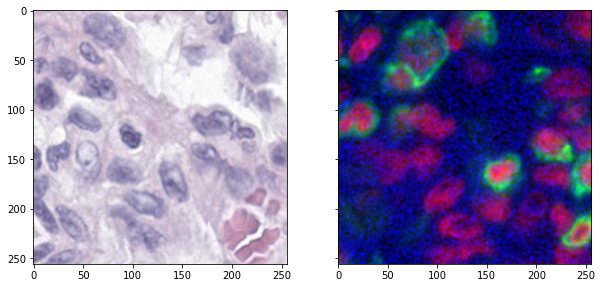

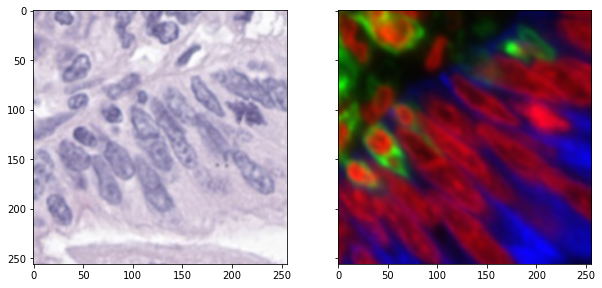

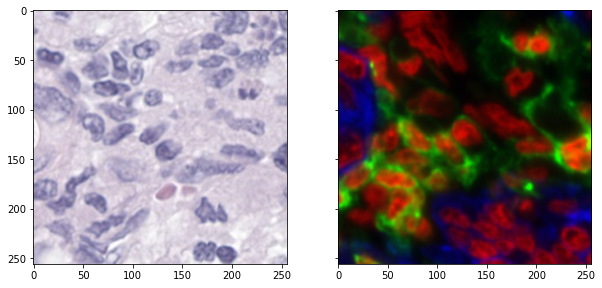

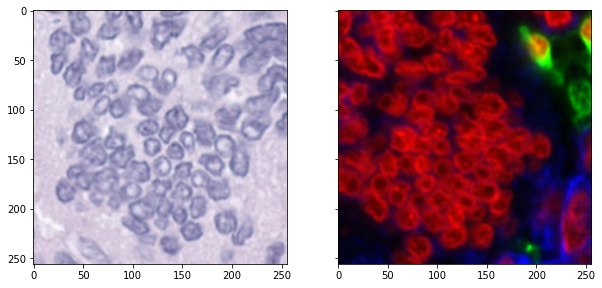

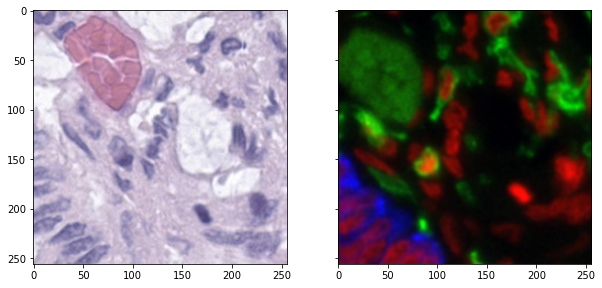

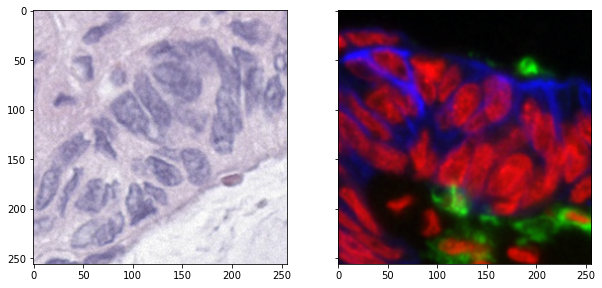

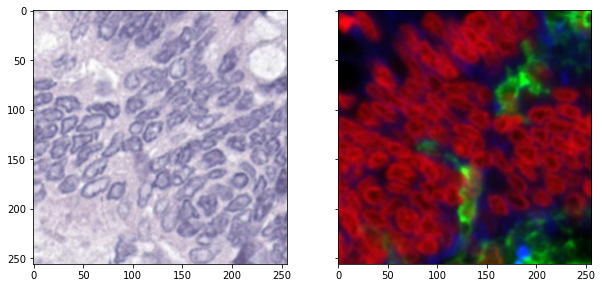

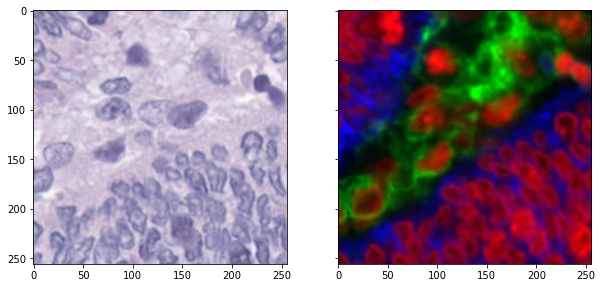

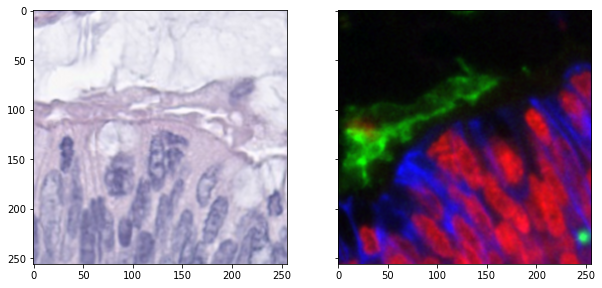

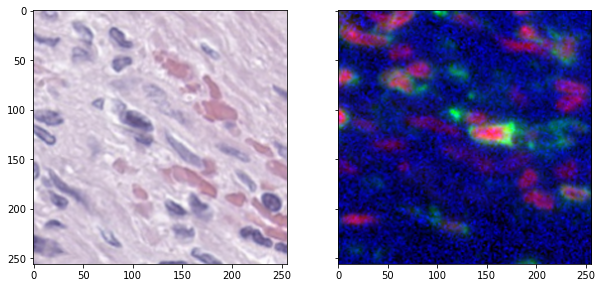

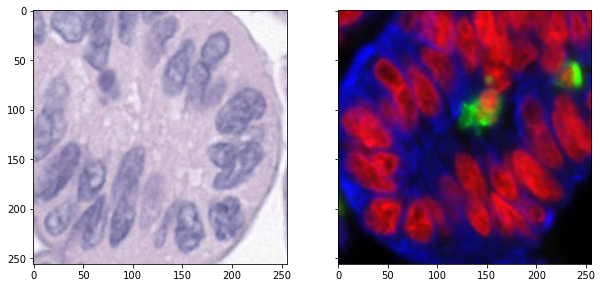

In [156]:
marker = ['Hoechst','AF1','CD31','CD45','CD68','Blank','CD4',
          'FOXP3','CD8a','CD45RO','CD20','PD-L1','CD3e','CD163',
          'E-Cadherin','PD-1','Ki-67','Pan-CK','SMA'
         ]

for i, data in enumerate(dataset): 
    A = data["A"]
    B = data["B"]
    
    img = torch.permute(A, (2, 1, 0))
    target = torch.permute(B, (2, 1, 0))
    BANDS = [0,3,17]
    titles = ["HE Image",  "IF - Target"]
    
    print(f"Range for HE]-> [{img.min(), img.max()}] - Shape: [{img.shape}]")
    print(f"Range for IF]-> [{target.min(), target.max()}] - Shape: [{target.shape}]")
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 10))
    axs[0].imshow(img)
    axs[1].imshow(target[:,:,BANDS])
    """
    fig_N_ch = plt.figure(figsize=(50, 50))
    # loop over images
    num_channels = 16# target.shape[2]
    list_targets = [target[:,:,ch] for ch in range(num_channels)]
    m = marker[:num_channels] # select equal number of channels to visualize
    plot_imgs(list_targets, m)
    #fig_N_ch.savefig(os.path.join(save_dir, f'data_{i}.pdf'))
    """
    if i ==10:
        break
        